In [97]:
import pandas as pd
import numpy as np
import itertools as it 
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, ConstantKernel as C

from ast import literal_eval

# Guide and Ideas for Capstone Project

We begin this guide by downloading the data:

In [98]:
#PARAMETERS 
# This section defines the variables to run the rest of the document 
file = 1  # Identifies the function number to execute (1,2,3...8) 
resultsFile = "data/results09.csv"   # The latest results file provided by Carlton on a weekly basis 
kernel_name = "polynomial"   # Options are default, linear and polynomial

In [99]:
inputColumnName = "f" + str(file)
outputColumnName = "f" + str(file) + "_output"
df = pd.read_csv(resultsFile)
input = df[inputColumnName]
output = df[outputColumnName]
print("Input=", input)
print("Output=", output)
df.head(25)


Input= 0    [0.877228 0.8796  ]
1    [0.877228 0.758174]
2    [0.785666 0.5864  ]
3    [0.800434 0.811483]
4    [0.824063 0.666364]
5    [0.700011 0.811483]
6    [0.762037 0.77002 ]
7    [0.753176 0.78779 ]
8    [0.877228 0.5864  ]
Name: f1, dtype: object
Output= 0    2.380231e-87
1   -1.758338e-55
2   -9.346589e-20
3    1.381414e-44
4    1.055608e-30
5   -1.535327e-27
6    4.857872e-27
7    2.058824e-29
8    1.227291e-45
Name: f1_output, dtype: float64


,Unnamed: 0,timestamp,student_id,f1,f2,f3,f4,f5,f6,f7,f8,f1_output,f2_output,f3_output,f4_output,f5_output,f6_output,f7_output,f8_output
0,24,2024-05-05 12:53:51,534,[0.877228 0.8796 ],[0.562109 0.999999],[0.463899 0.489275 0.408212],[0.462212 0.386621 0.366643 0.298809],[0.269027 0.999999 0.999999 0.999999],[0.582549 0.123754 0.586041 0.832796 0.045121],[0.046316 0.393338 0.197938 0.174495 0.336343 ...,[0.067737 0.079147 0.027514 0.046544 0.461641 ...,2.380231e-87,-0.006238,-0.027911,-1.917274,4462.544669,-0.583353,1.286160,9.799602
1,45,2024-05-07 07:25:14,534,[0.877228 0.758174],[0.843164 0.999999],[0.509702 0.39142 0.489854],[0.426175 0.38531 0.370372 0.358571],[0.322832 0.999999 0.999999 0.999999],[0.466039 0.148505 0.468833 0.666237 0.036097],[0.046316 0.393338 0.197938 0.174495 0.360367 ...,[0.081284 0.094976 0.033017 0.055853 0.369313 ...,-1.758338e-55,-0.029584,-0.009415,0.563498,4484.415611,-0.672251,1.708912,9.696555
2,82,2024-05-13 06:14:44,534,[0.785666 0.5864 ],[0.769352 0.892841],[0.371119 0.39142 0.489854],[0.34094 0.363106 0.444446 0.430285],[0.387398 0.999999 0.999999 0.999999],[0.466039 0.148505 0.703249 0.999355 0.036097],[0.037053 0.472006 0.15835 0.139596 0.319182 ...,[0.081284 0.094976 0.033017 0.055853 0.553969 ...,-9.346589e-20,0.268439,-0.007078,0.180900,4528.747422,-0.684715,1.033901,9.817107
3,206,2024-06-10 07:09:12,534,[0.800434 0.811483],[0.687022 0.999999],[0.422794 0.313136 0.498535],[0.34094 0.431025 0.296298 0.430285],[0.464878 0.999999 0.999999 0.999999],[0.372831 0.118804 0.562599 0.999999 0.043316],[0.037053 0.31467 0.237526 0.139596 0.43244 ...,[0.097541 0.113971 0.03962 0.067024 0.443175 ...,1.381414e-44,0.578437,-0.015200,-0.728106,4619.357394,-0.645317,1.401136,9.849910
4,265,2024-06-20 05:37:21,534,[0.824063 0.666364],[0.672828 0.952955],[0.556679 0.473172 0.489854],[0.485406 0.308248 0.444446 0.430285],[0.557854 0.999999 0.999999 0.999999],[0.494966 0.118804 0.843899 0.806398 0.043316],[0.037053 0.31467 0.15835 0.209394 0.288294 ...,[0.117049 0.136765 0.047544 0.080429 0.53181 ...,1.055608e-30,0.457030,-0.018150,-1.723890,4806.634380,-0.583558,2.145971,9.859542
5,307,2024-06-25 06:16:12,534,[0.700011 0.811483],[0.740962 0.999999],[0.668015 0.567806 0.587825],[0.390058 0.462372 0.444446 0.352494],[0.669425 0.999999 0.999999 0.999999],[0.634778 0.099003 0.703249 0.999355 0.054145],[0.029642 0.251736 0.12668 0.251273 0.230635 ...,[0.140459 0.109412 0.057053 0.096515 0.425448 ...,-1.535327e-27,0.281996,-0.039242,-0.576021,5200.648778,-0.813828,2.110076,9.833724
6,325,2024-06-28 04:06:03,534,[0.762037 0.77002 ],[0.685634 0.999999],[0.611642 0.358719 0.471252],[0.381391 0.365718 0.366606 0.430285],[0.80331 0.999999 0.999999 0.999999],[0.51425 0.148505 0.614333 0.815566 0.054145],[0.029642 0.251736 0.12668 0.167515 0.288294 ...,[0.093639 0.164118 0.057053 0.096515 0.486226 ...,4.857872e-27,0.514040,-0.022800,0.527600,6055.632249,-0.389504,2.025039,9.865061
7,361,2024-07-01 14:33:18,534,[0.753176 0.78779 ],[0.699513 0.999999],[0.611642 0.37061 0.587825],[0.34094 0.318697 0.444446 0.303874],[0.963972 0.999999 0.999999 0.999999],[0.4114 0.178206 0.635517 0.776194 0.064974],[0.029642 0.350632 0.12668 0.251273 0.313005 ...,[0.074911 0.131294 0.068464 0.115818 0.555687 ...,2.058824e-29,0.649630,-0.044824,-1.277253,8013.336006,-0.201555,2.078230,9.906853
8,425,2024-07-09 17:19:13,534,[0.877228 0.5864 ],[0.822761 0.999999],[0.556679 0.39142 0.32657 ],[0.34094 0.308248 0.296298 0.286857],[0.999999 0.999999 0.999999 0.999999],[0.32912 0.142565 0.76262 0.931433 0.051979],[0.029642 0.377604 0.12668 0.167515 0.230635 ...,[0.059929 0.105035 0.054771 0.092654 0.666824 ...,1.227291e-45,0.009378,-0.047107,-2.760482,8662.405001,-0.632356,1.371910,9.947503


In [100]:
# LOAD INITIAL DATA PROVIDED AT THE BEGINNING 
def load_data(dim):
    X = np.load('data/initial_data/function_' + str(dim) +'/initial_inputs.npy')
    y = np.load('data/initial_data/function_' + str(dim) +'/initial_outputs.npy')
    return X,y

# LOAD AND APPEND THE RESULTS PUBLISHED BY CARLTON 
X, y = load_data(file)
dimension = np.shape(X)[1] 

for item in input:
     item_with_comma = "[" + item.replace(" 0.",", 0.")  + "]"  
     row = np.array(literal_eval(item_with_comma))
     X = np.append(X, np.array(row), axis=0)

for item in output:
    y = np.append(y, float(item))

print("X(shape)=", X.shape, "y(shape)=", y.shape)


X(shape)= (19, 2) y(shape)= (19,)


In [101]:
X

array([[0.31940389, 0.76295937],
       [0.57432921, 0.8798981 ],
       [0.73102363, 0.73299988],
       [0.84035342, 0.26473161],
       [0.65011406, 0.68152635],
       [0.41043714, 0.1475543 ],
       [0.31269116, 0.07872278],
       [0.68341817, 0.86105746],
       [0.08250725, 0.40348751],
       [0.88388983, 0.58225397],
       [0.877228  , 0.8796    ],
       [0.877228  , 0.758174  ],
       [0.785666  , 0.5864    ],
       [0.800434  , 0.811483  ],
       [0.824063  , 0.666364  ],
       [0.700011  , 0.811483  ],
       [0.762037  , 0.77002   ],
       [0.753176  , 0.78779   ],
       [0.877228  , 0.5864    ]])

In [102]:
y


array([ 1.32267704e-079,  1.03307824e-046,  7.71087511e-016,
        3.34177101e-124, -3.60606264e-003, -2.15924904e-054,
       -2.08909327e-091,  2.53500115e-040,  3.60677119e-081,
        6.22985647e-048,  2.38023080e-087, -1.75833777e-055,
       -9.34658880e-020,  1.38141414e-044,  1.05560753e-030,
       -1.53532704e-027,  4.85787195e-027,  2.05882351e-029,
        1.22729090e-045])

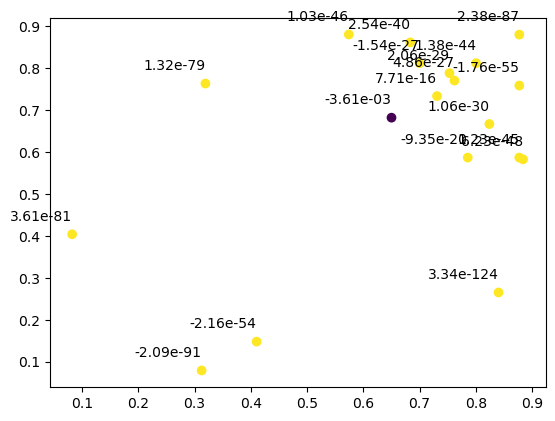

In [103]:
# The first 2 functions can be shown as X,Y coordinates and reveal what is going on. On higher dimensions it loses meaning so we don't plot it 
if (dimension == 1 or dimension == 2):
    x1 =X[:,0]
    x2 =X[:,1] 
    plt.scatter(x1, x2, c=y)
    for (i, j, text) in zip(x1, x2, y):
        plt.annotate(format(text, ".2e"),  # This is the text to use for the annotation
                 (i, j),  # This is the point to label
                 textcoords="offset points",  # how to position the text
                 xytext=(0,10),  # distance from text to points (x,y)
                 ha='right')  # horizontal alignment can be left, right or center
    plt.show()



# Upper Confidence Bound

A second alternative would be to use Bayesian Optimization and consider an Upper Confidence Bound acquisition function: 

In [104]:
# Add here hyper-parameters
if (kernel_name == "linear"):
    kernel = C(1.0, constant_value_bounds="fixed") * DotProduct(sigma_0=1.0)
else:
    kernel = C(1.0, constant_value_bounds="fixed") * RBF(1.0, length_scale_bounds="fixed")

gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(X, y)



GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1))

In [105]:
def find_maxiumum(X, y):
    maximum_of_X = []
    maximum_so_far = -1e99
    for index in range(len(y)):
        if (y[index] > maximum_so_far):
            maximum_so_far = y[index]
            maximum_of_X = []
            for i in range(dimension):
                maximum_of_X.append(X[index, i])
    return np.array(maximum_of_X), maximum_so_far
    
discovery_radius = 0.2   # on each datapoint use 20% discovery radius

Xmax, ymax = find_maxiumum(X, y)  #Returns the row with maximim y and all X values 
XmaxLower = Xmax - (Xmax * discovery_radius)
XmaxUpper = Xmax + (Xmax * discovery_radius)
print("maximum X=", Xmax, ", maximum y=", ymax)

# Adjust sizes as we go up in dimensions to avoid waiting for hours on higher dimensions 
# ********* For the purpose of unblocking any memory issue please decrease these values to adjust to your computer specs ******************
sizes = [ [2, 100],
          [3,  80],
          [4,  60],
          [5,  30],
          [6,  15],
          [7,  10],
          [8,  8]]

size = sizes[dimension - 2][1]  #Find the corrects size for this dimension 

data = []
for item in range(dimension):
    #  Upper lower min and max explanation: 
    #  This iteration (each X value) creates a number of points of size "size" in a radius of +/-20% and ensures this radius is between 0 and 1, e.g.  
    # - X values [0.5, 0, 0.99] 
    # - apply 20% discovery radius => [(0.4 to 0.6), (0 to 0), (0.792 to 1.188)] 
    # - apply 0 to 1 filter => [ linspace(0.4 to 0.6), linspace(0 to 0.0001), linspace(9.792 to 9.9999)]
    # - result = [ [0.48777254 ... 0.59072617], [0.000002, ... 0.000099], [9.7921111, ...9.998888] ]
    if (XmaxUpper[item] == 0):
        XmaxUpper[item] = 0.0001
    if (XmaxLower[item] == 1):
        XmaxLower[item] = 0.9999
    data.append(np.linspace(max(XmaxLower[item], 0 + 1e-10), min(XmaxUpper[item], 1 - 1e-10), size))

x_grid_points = np.array(data)

print("data-points=", x_grid_points.shape)
for dim in range(dimension):
    print("data-points[", dim + 1, "]=", x_grid_points[dim][:5], "...", x_grid_points[dim][-1] )



maximum X= [0.73102363 0.73299988] , maximum y= 7.710875114502849e-16
data-points= (2, 100)
data-points[ 1 ]= [0.5848189  0.58777254 0.59072617 0.5936798  0.59663343] ... 0.8772283571476303
data-points[ 2 ]= [0.5863999  0.58936152 0.59232313 0.59528475 0.59824636] ... 0.8795998516982727


In [106]:
# Apply grid search = cartesian product of the array, e.g. data of shape (2,100) => (100 x 100) = (10000, 2)
X_grid = np.fromiter(it.chain(*it.product(*x_grid_points)), dtype=float).reshape(-1,dimension)
print("X_grid=", X_grid.shape, " = ", X_grid[0:5,:], "...", X_grid[-1,:])


X_grid= (10000, 2)  =  [[0.5848189  0.5863999 ]
 [0.5848189  0.58936152]
 [0.5848189  0.59232313]
 [0.5848189  0.59528475]
 [0.5848189  0.59824636]] ... [0.87722836 0.87959985]


In [107]:
mean, std = gpr.predict(X_grid, return_std = True)

def calculate_ucb(beta):   
    ucb = mean + beta * std
    print("UCB=", ucb.shape, ", value=", ucb[:5])
    print("mean=", mean.shape, ", value=", mean[:5])
    idx_max = np.argmax(ucb)   # take the index of the highest confidence result 
    next_query = X_grid[idx_max]    # next_query is the point with highest confidence in this grid of search 
    best_numbers = []
    for item in next_query:
        best_numbers.append(min(max(item, 0.000001), 0.999999))   # ensure the numbers are between 0 and 1 
    print(best_numbers)
    return best_numbers

def print_results(label, best_numbers):
    #Formats the values in a way it can be copied and pasted into the weekly submission form 
    print(label)
    print(np.array2string(np.array(best_numbers), precision=6, separator='-', floatmode='fixed', formatter={'float': '{:0.6f}'.format}))

print("balanced")
balanced = calculate_ucb(1.96)  #keep it balanced

print("\n\nexploitative")
exploitative = calculate_ucb(1.0)   #lets exploit target area

print("\n\nexploratory")
exploratory = calculate_ucb(2.5)   #lets explore more 



balanced
UCB= (10000,) , value= [-0.01175514 -0.01168296 -0.01160797 -0.01153021 -0.01144973]
mean= (10000,) , value= [-0.01199213 -0.0119135  -0.01183217 -0.01174819 -0.01166161]
[0.7502222313653135, 0.7907513818297602]


exploitative
UCB= (10000,) , value= [-0.01187121 -0.01179588 -0.01171778 -0.01163698 -0.01155351]
mean= (10000,) , value= [-0.01199213 -0.0119135  -0.01183217 -0.01174819 -0.01166161]
[0.7502222313653135, 0.7907513818297602]


exploratory
UCB= (10000,) , value= [-0.01168984 -0.01161944 -0.0115462  -0.01147015 -0.01139135]
mean= (10000,) , value= [-0.01199213 -0.0119135  -0.01183217 -0.01174819 -0.01166161]
[0.8772283571476303, 0.6634019083515592]


In [108]:

print_results("exploitative", exploitative)

print_results("\nbalanced", balanced)

print_results("\nexploratory", exploratory)


exploitative
[0.750222-0.790751]

balanced
[0.750222-0.790751]

exploratory
[0.877228-0.663402]
